In [1]:
%load_ext autoreload
%autoreload 3

import fv_mapz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload 

%load_ext fortranmagic

#---------------------------------------------------------------------
def write_Z_profile(data, data_keys = ['OLD_PE', 'NEW_PE', 'OLD_DZ', 'NEW_DZ', 'OLD_W', 'NEW_W']):
    
    from columnar import columnar
        
    newlist = []
    newlist.append(np.arange(data['NEW_PE'].shape[0]).tolist())
    
    headers = ['level']
    
    for key in data_keys:
        
        newlist.append(data[key][:].tolist())
        headers.append(key)

    # need to rearange all the data into row like an excel spreadsheet
    
    row_data = [list(x) for x in zip(*newlist)]
        
    table = columnar(row_data, headers, no_borders=True)
    print(table)


In [2]:
%%file sim_w_1d.f90

!>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
subroutine SIM_W_1D(dt, km, rgas, gama, gm2, cp2, kappa, pe, dm2, pm2, pem, w2, dz2, pt2, ws, p_fac, pe_compute)
                        
   integer,       intent(in)  :: km, pe_compute
   real(kind=4),  intent(in)  :: dt, rgas, gama, kappa, p_fac
   real(kind=4),  intent(in), dimension(km):: dm2, pt2, pm2, gm2, cp2
   real(kind=4),  intent(in ) :: ws
   real(kind=4),  intent(in ), dimension(km+1):: pem
   real(kind=4),  intent(inout) :: pe(km+1), dz2(km), w2(km)
   
   !f2py intent(overwrite) :: pe, dz2, w2

! Local variables

   real(kind=4), dimension(km  ):: Ak, Bk, Rk, Ck, g_rat, bb, dd, aa, cc, dz1, w1
   real(kind=4), dimension(km+1):: pp, gam, wE, dm2e, wES
   real  rdt, capa1, bet, r3
    
   real :: dwup, dwcn, dwdn, dmtot, wup, wdn, wcn, dzup, dzdn, dzcn, ddmup, ddmcn, ddmdn

   rdt   = 1. / dt
   capa1 = kappa - 1.
   r3    = 1./3.

! Compute non-hydrostatic pert pressure

   do k = 1,km
    
     pp(k)   = exp(gama*log(-dm2(k)/dz2(k)*rgas*pt2(k))) - pm2(k)        
     dm2e(k) = dm2(k)
    
     w1(k)   = w2(k)
     dz1(k)  = dz2(k)
    
   enddo

   dm2e(km+1) = dm2(km)
    
! Set up tridiagonal coeffs for spline interpolation of w to grid edges. (Extra copy of bb for end calcs)

    do k = 2,km
       
      g_rat(k) = dm2e(k-1)/dm2e(k)
    
      aa(k)    = 1.0
      bb(k)    = 2.*(1.+g_rat(k))
      cc(k)    = g_rat(k)
      dd(k)    = 3.*(w1(k) + cc(k)*w1(k+1))

    enddo
    
! Boundary conditions for von Neuman at the top

    bb(1) = 2.0
    cc(1) = 1.0
    dd(1) = 3.0*w1(1)

! Boundary conditions at the bottom...

    bb(km) = 2.
    dd(km) = 3.*w1(km)
    wE(km+1) = 0.0
    
! Forward calculation of tri-diagonal system  # VBA algorithm from Wikipedia

    do k = 2, km
    
      bet   = aa(k) / bb(k-1)
      bb(k) = bb(k) - bet * cc(k-1)
      dd(k) = dd(k) - bet * dd(k-1)
         
    enddo

! Solve for the last value of matrix
        
      wE(km)   = dd(km) / bb(km)

! Do the back substition, result is wE on zone edges.

    do k = km-1, 2, -1

      wE(k) = (dd(k) - cc(k) * wE(k+1)) / bb(k)
        
    enddo
    
    wE(1) = wE(2)
    
! Store off the edge values

    do k = 1, km+1
    
      wES(k) = wE(k)
        
    enddo 
    
! New solver create nh-pe values for later update.

! Create PE's from original code....

    do k=1,km-1
      g_rat(k) = dm2(k)/dm2(k+1)
         bb(k) = 2.*(1.+g_rat(k))
         dd(k) = 3.*(pp(k) + g_rat(k)*pp(k+1))
    enddo

    bet = bb(1)
    pp(1) = 0.
    pp(2) = dd(1) / bet
    bb(km) = 2.
    dd(km) = 3.*pp(km)

! Forward calculation of tri-diagonal system

    do k=2,km
      gam(k) =  g_rat(k-1) / bet
      bet    =  bb(k) - gam(k)
      pe(k+1) = (dd(k) - pe(k) ) / bet
    enddo

! Do the back substition, result is pp on zone edges.

    do k=km, 2, -1
       pe(k) = pe(k) - gam(k)*pe(k+1)
    enddo
    
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Now start the implicit solver

! Compute cell centered tridiagonal coefficients 

    do k = 1, km
    
      Ak(k) = dt * gama * (pm2(k)+pp(k)) / dz1(k) 
        
    enddo

! Compute edge centered tridiagonal coefficients and RHS

    do k = 2, km

      Ck(k) = 2.0 * dt / (dm2(k) + dm2(k-1))
    
      aa(k) = Ak(k-1)*Ck(k)
        
      cc(k) = Ak(k  )*Ck(k)
    
      dd(k) = wE(k) + Ck(k) * (pp(k) - pp(k-1))
        
      bb(k) = 1.0 - cc(k) - aa(k)

    enddo    

! Boundary value calc for forward tri-diagonal solution

! von Neuman conditions

   bb(2) = 1 - aa(2)
    
   dd(km) = dd(km) - 0.0 * Ck(km)   ! this includes the lower bc for ws  (zero here)
  
! Forward calculation of tri-diagonal system  # VBA algorithm from Wikipedia

    do k = 3, km
    
      bet   = aa(k) / bb(k-1)
      bb(k) = bb(k) - bet * cc(k-1)
      dd(k) = dd(k) - bet * dd(k-1)
         
    enddo

! Solve for the last value of matrix
        
      wE(km)   = dd(km) / bb(km)
        
      wE(km+1) = 0.0
        
! Do the back substition, result is wE on zone edges.

    do k = km-1, 2, -1

      wE(k) = (dd(k) - cc(k) * wE(k+1)) / bb(k)
        
    enddo
    
    wE(1) = wE(2)
        
! Solve for new perturbation pressure at the cell centers.

    do k = 1, km

      pp(k)  = pp(k) - Ak(k) * (wE(k+1) - wE(k))

    enddo
    
! Use new pp at cell centers to get new dz's

    do k = 1, km
    
      dz2(k) = -dm2(k)*rgas*pt2(k)*exp(capa1*log(pp(k)+pm2(k)))

    enddo
    
! Need to generate new w at cell centers...use the time tendency of dz

    w2(km) = ( wE(km) + 2.*wE(km+1) )*r3
    
    do k = km-1,1,-1

     !w2(k) = 0.5*(wE(k) + wE(k+1))
        
     w2(k) = (wE(k) + bb(k)*wE(k+1) + g_rat(k)*wE(k+2))*r3 - g_rat(k)*w2(k+1)
        
    enddo
    
    pe(1) = 0.0
    
    if( pe_compute .eq. 1 ) THEN
    
      do k=1,km
          pe(k+1) = pe(k) + dm2(k)*(w2(k)-w1(k))*rdt
      enddo

    ENDIF 
    
    IF( pe_compute .eq. 2 ) THEN
    
! Edge code from original nh_utils/SIM1

        do k=1,km-1
          g_rat(k) = dm2(k)/dm2(k+1)
             bb(k) = 2.*(1.+g_rat(k))
             dd(k) = 3.*(pp(k) + g_rat(k)*pp(k+1))
        enddo

        bet = bb(1)
        pp(1) = 0.
        pp(2) = dd(1) / bet
        bb(km) = 2.
        dd(km) = 3.*pp(km)

! Forward calculation of tri-diagonal system

        do k=2,km
          gam(k) =  g_rat(k-1) / bet
          bet    =  bb(k) - gam(k)
          pe(k+1) = (dd(k) - pe(k) ) / bet
        enddo

! Do the back substition, result is pp on zone edges.

        do k=km, 2, -1
           pe(k) = pe(k) - gam(k)*pe(k+1)
        enddo
            
    ENDIF

   IF( pe_compute .eq. 3 ) THEN
    
! Solve for new perturbation pressure at the cell EDGES

     do k = 2, km

       pe(k)  = pe(k) - 0.5*(Ak(k)+Ak(k-1)) * (w2(k) - w2(k-1))

     enddo
            
    ENDIF
    
end subroutine SIM_W_1D


Overwriting sim_w_1d.f90


In [3]:
!rm sim_w_1d.cpython-39-x86_64-linux-gnu.so

!fcompile.py



   ---> Removing all module files...safety first!


rm: cannot remove '*.mod': No such file or directory

Fortran object files compiled:   



rm: cannot remove 'sim_w_1d.so': No such file or directory


 ==> f2py --debug --fcompiler=gnu95 --f90flags='-O1 -funroll-loops -fopenmp -fPIC -I/usr/local/include' -DF2PY_REPORT_ON_ARRAY_COPY -c -m sim_w_1d sim_w_1d.f90  -lgomp -L/usr/local/lib  


running build
running config_cc
unifing config_cc, config, build_clib, build_ext, build commands --compiler options
running config_fc
unifing config_fc, config, build_clib, build_ext, build commands --fcompiler options
running build_src
build_src
building extension "sim_w_1d" sources
f2py options: []
f2py:> /tmp/tmp7z1slde7/src.linux-x86_64-3.9/sim_w_1dmodule.c
creating /tmp/tmp7z1slde7/src.linux-x86_64-3.9
Reading fortran codes...
	Reading file 'sim_w_1d.f90' (format:free)
Post-processing...
	Block: sim_w_1d
			Block: sim_w_1d
Post-processing (stage 2)...
Building modules...
	Building module "sim_

In [4]:
# read text filea into pandas DataFrame and label columns
#
df1 = pd.read_fwf("fort/fort.1",header=None)

df2 = pd.read_fwf("fort/fort.2", header=None)

df3 = pd.read_fwf("fort/fort.3", header=None)

df_pE = pd.read_fwf("fort/fort.4", header=None)

dfPre = pd.concat([df1, df2, df3], axis=1)
dfPre.columns = ['k', 'pe', 'pm2', 'w2', 'dz2', 'dm2', 'pt2', 'gm2', 'cp2']

before = {}

nz = 60
nrec = len(dfPre['k'])
ntime = int(nrec/nz)
print(ntime)

for key in ['k', 'pe', 'pm2', 'w2', 'dz2', 'dm2', 'pt2', 'cp2', 'gm2']:
    
    before[key] = dfPre[key].to_numpy(dtype='float32').reshape(ntime,nz)

before['pem'] = df_pE[0].to_numpy(dtype='float32').reshape(ntime, nz+1)


df1 = pd.read_fwf("fort/fort.97",header=None)

df2 = pd.read_fwf("fort/fort.98", header=None)

dfPost = pd.concat([df1, df2], axis=1)
dfPost.columns = ['k', 'pe', 'pm2', 'w2', 'dz2', 'dm2']

after = {}


for key in ['k', 'pe', 'pm2', 'w2', 'dz2', 'dm2']:
    
    after[key] = dfPost[key].to_numpy(dtype='float32').reshape(ntime,nz)
    
########################################################################

time = 60

data = {}
    
data['NEW_PE'], data['NEW_DZ'],data['NEW_W'] = after['pe'][time], after['dz2'][time], after['w2'][time]

data['OLD_PE'], data['OLD_DZ'], data['OLD_W'] = before['pe'][time], before['dz2'][time], before['w2'][time]

#write_Z_profile(data)
    

324


This module 'sim_w_1d' is auto-generated with f2py (version:1.20.3).
Functions:
  sim_w_1d(dt,rgas,gama,gm2,cp2,kappa,pe,dm2,pm2,pem,w2,dz2,pt2,ws,p_fac,pe_compute,km=len(gm2),overwrite_pe=1,overwrite_w2=1,overwrite_dz2=1)
.


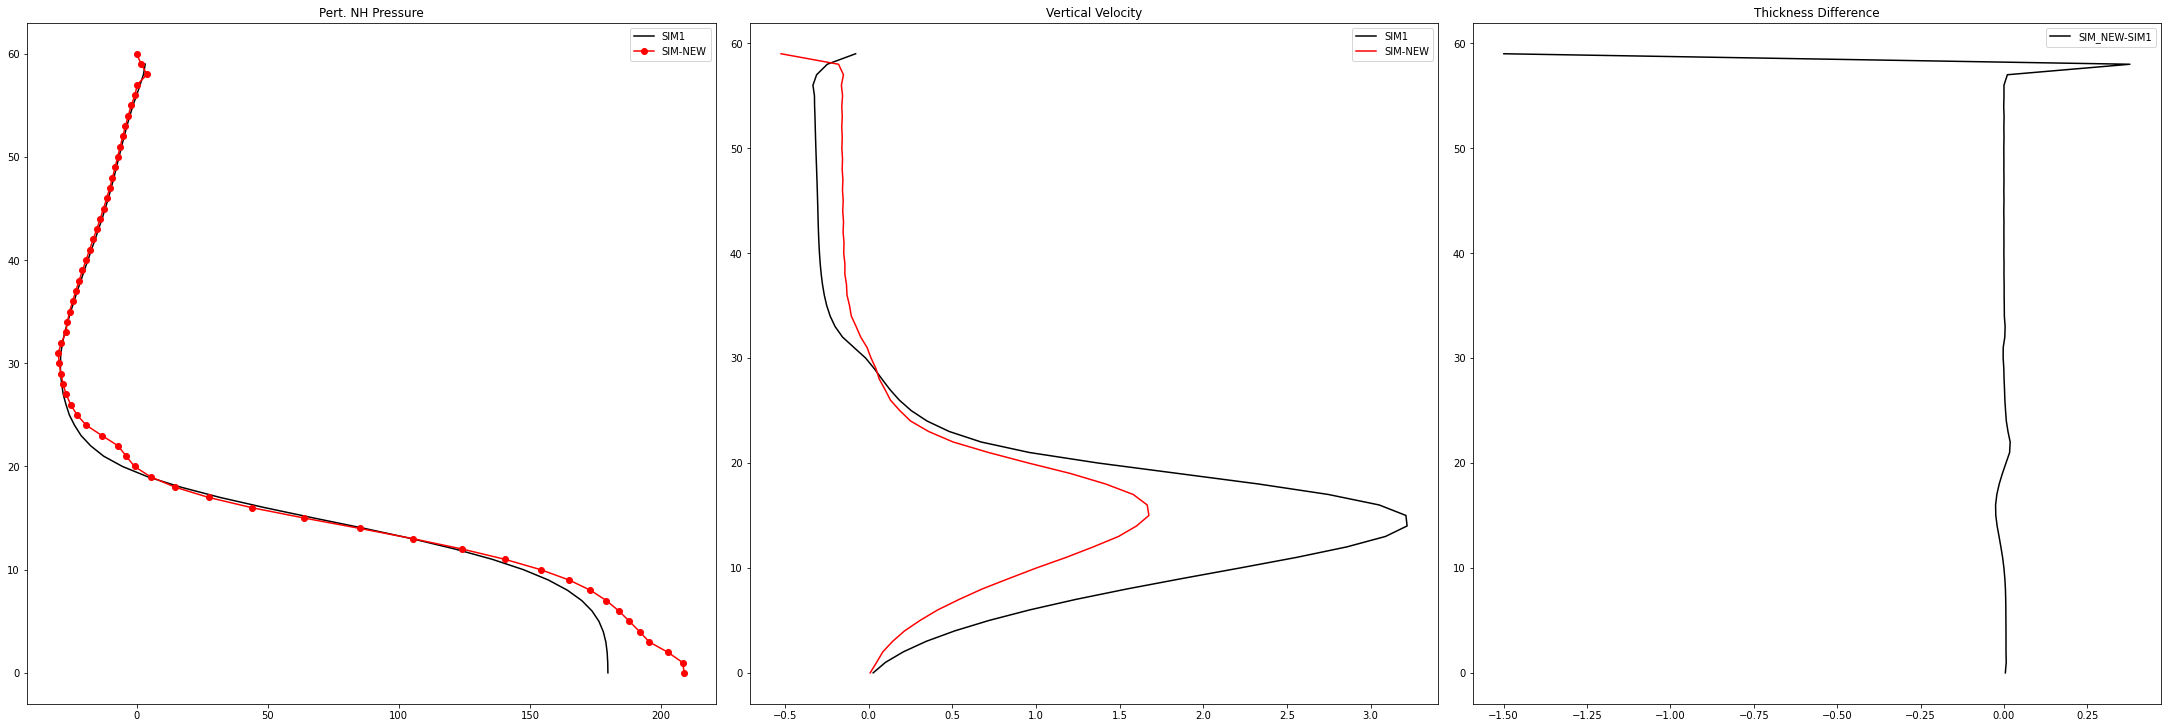

In [5]:
import sim_w_1d

sim_w_1d = reload(sim_w_1d)

print(sim_w_1d.__doc__)

dt    =  0.166666666666667        
rgas  = 287.050000000000        
gama  = 1.40004180893318
kappa = 0.285735616165638       
p_fac = 0.000000000000000
ws    = 0.0

time = 100

pe = np.zeros((nz+1,), dtype='float32')
pe[1:] = before['pe'][time,:]

dz2 = before['dz2'][time,:].copy()
w2  = before['w2'][time,:].copy()

# print(np.obj2sctype(dz2))
# print(np.obj2sctype(w2))

sim_w_1d.sim_w_1d(dt, rgas, gama, before['gm2'][time,:], before['cp2'][time,:], kappa, pe, \
                                  before['dm2'][time,:], before['pm2'][time,:], before['pem'][time,:], \
                                  w2,  dz2, before['pt2'][time,:], ws, p_fac, 2)

#write_Z_profile(data,data_keys = ['OLD_PE', 'NEW_PE', 'OLD_DZ', 'NEW_DZ', 'OLD_W', 'NEW_W'] )

km = w2.shape[0]

fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]

ax.plot(after['pe'][time,::-1], np.arange(km), color='k', label='SIM1')
ax.plot(pe[::-1], np.arange(km+1), marker='o', color='r', label='SIM-NEW')
ax.set_title('Pert. NH Pressure')
ax.legend()

ax = axes[1]

ax.plot(after['w2'][time,::-1], np.arange(km), color='k', label='SIM1')
ax.plot(w2[::-1], np.arange(km), color='r', label='SIM-NEW')
ax.set_title('Vertical Velocity')
ax.legend()

ax = axes[2]

ax.plot(dz2[::-1]-after['dz2'][time,::-1], np.arange(km), color='k', label='SIM_NEW-SIM1')
ax.set_title('Thickness Difference')
ax.legend()

plt.show()

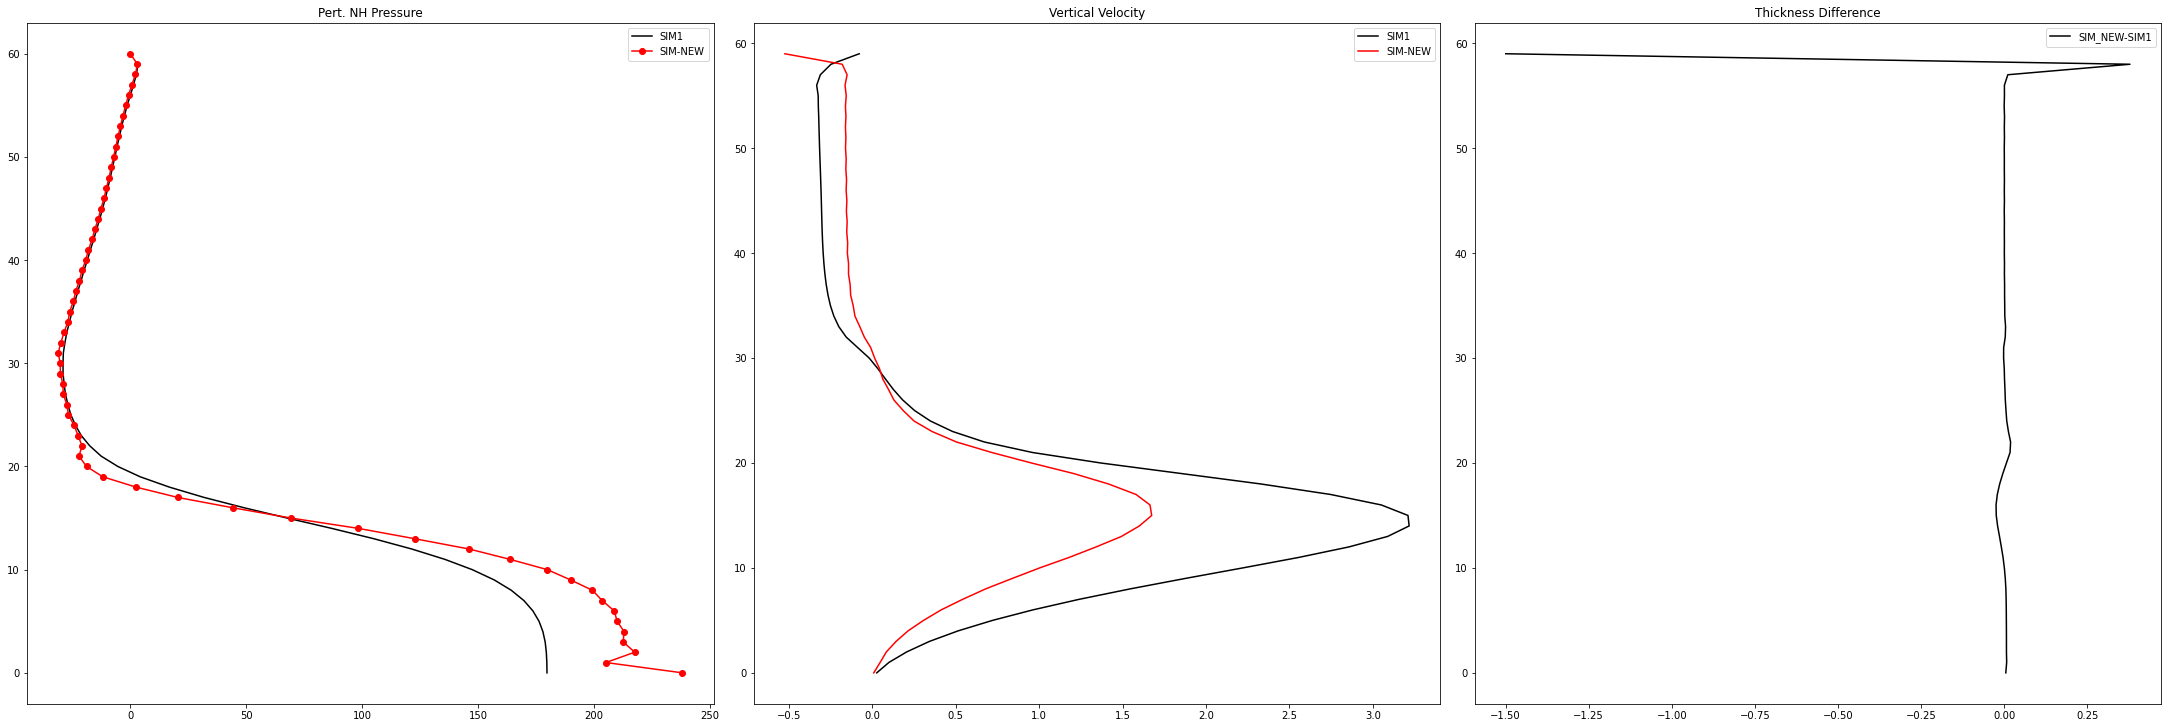

In [6]:
dt    =  0.166666666666667        
rgas  = 287.050000000000        
gama  = 1.40004180893318
kappa = 0.285735616165638       
p_fac = 0.000000000000000
ws    = 0.0

pe = np.zeros((nz+1,), dtype='float32')
pe[1:] = before['pe'][time,:]

dz2 = before['dz2'][time,:].copy()
w2  = before['w2'][time,:].copy()

# print(np.obj2sctype(dz2))
# print(np.obj2sctype(w2))

sim_w_1d.sim_w_1d(dt, rgas, gama, before['gm2'][time,:], before['cp2'][time,:], kappa, pe, \
                                  before['dm2'][time,:], before['pm2'][time,:], before['pem'][time,:], \
                                  w2,  dz2, before['pt2'][time,:], ws, p_fac, 3)

#write_Z_profile(data,data_keys = ['OLD_PE', 'NEW_PE', 'OLD_DZ', 'NEW_DZ', 'OLD_W', 'NEW_W'] )

km = w2.shape[0]

fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]

ax.plot(after['pe'][time,::-1], np.arange(km), color='k', label='SIM1')
ax.plot(pe[::-1], np.arange(km+1), marker = 'o', color='r', label='SIM-NEW')
ax.set_title('Pert. NH Pressure')
ax.legend()

ax = axes[1]

ax.plot(after['w2'][time,::-1], np.arange(km), color='k', label='SIM1')
ax.plot(w2[::-1], np.arange(km), color='r', label='SIM-NEW')
ax.set_title('Vertical Velocity')
ax.legend()

ax = axes[2]

ax.plot(dz2[::-1]-after['dz2'][time,::-1], np.arange(km), color='k', label='SIM_NEW-SIM1')
ax.set_title('Thickness Difference')
ax.legend()

plt.show()